## FEATURE SELECTION - FootySage

En este cuaderno se define un flujo de trabajo para la selección y análisis de características relevantes utilizando los datos de *Open Data* de ***StatsBomb***. 

Este proceso comienza con la integración de información proveniente de diversas fuentes, como partidos, alineaciones y eventos, consolidándola en un dataset estructurado. Cada fila del dataset representa un partido, enriquecido con métricas calculadas que reflejan aspectos clave del rendimiento, como estadísticas agregadas de pases, disparos, recuperaciones, faltas, entre otros.

A partir de este dataset, se entrenarán modelos básicos de Machine Learning, como Árboles de Decisión (Decision Tree), Regresión Logística (Logistic Regression) y K-Nearest Neighbors (KNN). El objetivo es evaluar su capacidad de clasificación y obtener conclusiones sobre la influencia de las características seleccionadas. Este enfoque inicial proporcionará una base sólida para ampliar el análisis hacia conjuntos de datos más extensos e implementar modelos más avanzados en futuras fases del proyecto.

### Estudio de una competición en una temporada (Competición regular)

#### Carga y procesamiento de datos (extracción y estructuración)

En primer lugar seleccionamos la competición y la temporada de esa competición que queremos estudiar.

In [440]:
from src.fetch_data import get_competition_id_and_season_id


# seleccionamos el torneo a estudiar (competición, temporada y género)
competition_name = "La Liga"
competition_gender = "male"
season_name = "2015/2016"
season_name_for_filename = "2015_2016"

competition_id, season_id = get_competition_id_and_season_id(competition_name, competition_gender, season_name)
print(f"We are going to study the tournament {competition_name + ' (' + season_name + ', ' + competition_gender + ')'} whose competition_id={competition_id} and season_id={season_id}")

We are going to study the tournament La Liga (2015/2016, male) whose competition_id=11 and season_id=27


Dada esa competición vamos a obtener cuales son todos los partidos que se han jugado en tal competición esa temporada.

In [441]:
from src.fetch_data import get_matches


matches_df = get_matches(competition_id, season_id)
print(f"Number of matches in the competition that season: {matches_df.shape[0]}")

# comprobamos que todos los partidos estén disponibles para obtener información
column_name = "match_status"
if matches_df[column_name].nunique() == 1: 
    print(f"All values in column '{column_name}' are equal: {matches_df[column_name].iloc[0]}")
else:
    print(f"The values in column '{column_name}' are different.")

Number of matches in the competition that season: 380
All values in column 'match_status' are equal: available


Tras tener todos los partidos de la competición ordenados a nuestro gusto, nos disponemos a obtener los datos relacionados con eventos, alineaciones... de cada partido. 

Estos datos son ('(x2)' se refiere tanto al equipo de casa como al de fuera y 'x' en el nombre de la variable hace referencia a 'home' y 'away'):
- Estadísticas generales:
  - Tiros:
    - Número de tiros totales (x2) --> total_shots_x
    - Ratio de tiros a puerta (x2) --> shots_on_target_ratio_x
    - Distancia promedio a la portería desde donde se hacen los tiros a puerta (x2) --> average_shot_on_target_distance_x
    - Tiros con alto xG (umbral > 0.2) (x2) --> shots_high_xG_x
    - Número de tiros dentro del área (x2) --> shots_inside_area_x
    - Ratio de tiros dentro del área (x2) --> shots_inside_area_ratio_x
    - Número de tiros con el pie (derecho e izquierdo) (x2) --> shots_foot_x
    - Número de tiros con la cabeza (x2) --> shots_head_x
    - Número de tiros con otra parte del cuerpo (x2) --> shots_other_x
  - Pases:
    - Número de pases realizados (x2) --> total_passes_x
    - Precisión de pases realizados (x2) --> pass_success_ratio_x
    - Número de pases claves realizados (x2) --> key_passes_x
    - Número de pases necesarios para hacer un gol (x2) --> passes_needed_to_make_a_shot_x
    - Número de centros al área ralizados (x2) --> cross_x
    - Precisión de los centros al área (x2) --> cross_success_ratio_x
    - Número de corners (x2) --> corners_x
  - Defensa:
    - Número de intercepciones realizadas con éxito (x2) --> interceptions_won_x
    - Número de recuperaciones/robos (x2) --> recoveries_x
    - Número de bloqueos realizados (x2) --> blocks_x
    - Número de duelos ganados (x2) --> duels_won_x
    - Número de entradas realizadas (x2) --> tackles_x
    - Ratio de entradas exitosas (x2) --> tackles_success_ratio_x
    - Número de faltas cometidas por equipo (x2) --> fouls_committed_x
    - Número de balones divididos (50-50) ganados (x2) --> 50_50_won_x
    - Número de despejes por equipo (x2) --> clearance_x
    - Número de penaltis cometidos (x2) --> penaltys_committed_x
    - Número de errores claves cometidos (x2) --> key_errors_x
    - Número de pérdidas debido a malos controles (x2) --> miscontrol_x
    - Número de tarjetas amarillas (x2) --> yellow_cards_x
    - Número de tarjetas rojas (x2) --> red_cards_x
  - Presión:
    - Número de presiones realizadas (x2) --> pressures_x
    - Número de presiones inmediatas tras pérdida (x2) --> counterpress_x
    - Presiones realizas en tercio ofensivo (x2) --> pressures_in_attacking_third_x
  - Otros:
    - Número de fueras de juego (x2) --> offside_x
    - Número de dribbles intentados (x2) --> dribbles_x
    - Ratio de dribbles exitosos (x2) --> dribbles_success_ratio_x
    - Número de cambios por lesión (x2) --> injuries_substitution_x
    - Número de jugadores lesionados que han abandonado el campo sin hacer una sustitución (x2) --> players_off_x
    - Número de pérdidas de balón (x2) --> dispossessed_x
    - Número de contragolpes/contrataques (x2) --> counterattacks_x
    - Porcentaje de posesión (x2) --> possession_percentage_x
- Estadísticas contextuales:
  - Recuperaciones:
    - Recuperaciones en tercio ofensivo (x2) --> recoveries_attacking_third_x
    - Recuperaciones en tercio medio (x2) --> recoveries_middle_third_x
    - Recuperaciones en tercio defensivo (x2) --> recoveries_defensive_third_x
  - Eventos bajo presión:
    - Tiros realizados bajo presión (x2) --> shots_under_pressure_x
    - Tiros realizados sin presión en el área (x2) --> shots_without_pressure_inside_area_x 
    - Pases realizados bajo presión (x2) --> passes_under_pressure_x
    - Pases realizados sin presión en el área (x2) --> passes_without_pressure_inside_area_x
  - Jugadas a balón parado:
    - Tiros generados desde jugadas a balón parado (x2) --> set_piece_shots_x
    - Tiros en el área generados desde jugadas a balón parado (x2) --> set_piece_shots_inside_area_x
    - Ratio de tiros a puerta generados desde jugadas a balón parado (x2) --> set_piece_shots_on_target_ratio_x
- Tácticas:
  - Número de substituciones realizadas (x2) --> substitutions_x
  - Número de substituciones debido a una razón táctica realizadas (x2) --> tactical_substitutions_x
  - Número de cambios tácticos realizados (x2) --> tactical_changes_x
  - Número de veces que se cambia la formación en el partido (x2) --> formation_changes_x
- Métricas temporales:
  - Rendimiento partidos pasados:
    - Resumen de los últimos 3 partidos (3|1|0) (x2) --> last_3_matches_form_x
    - Es válido el resumen de los últimos 3 partidos (boolean) (x2) --> is_valid_last_3_matches_form_x
    - Porcentaje de victoria en los últimos 5 partidos (x2) --> win_rate_last_5_matches_x
    - Es válido el porcentaje de victoria en los últimos 5 partidos (boolean) (x2) --> is_valid_win_rate_last_5_matches_x
    - Victoria en el último partido en casa del equipo local (boolean) --> win_last_home_match_home_team
    - Es válida la última victoria en el último partido en casa del equipo local (boolean) --> is_valid_win_last_home_match_home_team
    - Victoria en el último partido fuera del equipo visitante (boolean) --> win_last_away_match_away_team
    - Es válida la última victoria en el último partido fuera del equipo visitante (boolean) --> is_valid_win_last_away_match_away_team
  - Último partido:
    - Número de goles concedidos en el último partido (x2) --> goals_conceded_last_match_x
    - Es válido el número de goles concedidos en el último partido (boolean) (x2) --> is_valid_goals_conceded_last_match_x
    - Número de goles anotados en el último partido (x2) --> goals_scored_last_match_x
    - Es válido el número de goles anotados en el último partido (boolean) (x2) --> is_valid_goals_scored_last_match_x
  - Consistencia:
    - Desviación estándar de tiros en los últimos 3 partidos (x2) --> std_shots_last_3_matches_x
    - Es válida la desviación estándar de tiros en los últimos 3 partidos (boolean) (x2) --> is_valid_std_shots_last_3_matches_x
- Equipo ganador --> winner_team (home_team, away_team, draw)

In [442]:
from src.data_processing import process_all_matches
import pandas as pd
import os


output_dir = "data/processed/"
filename = f"{competition_name}({season_name_for_filename}_{competition_gender})_processed.csv"
output_path = os.path.join(output_dir, filename)

# comprobamos si ya hemos procesado los partidos de la competición en esa temporada
if os.path.exists(output_path):    # si ya los hemos procesado, los cargamos
    print(f"Matches from the competition already processed and saved in {output_path}")
    print("If you want to process again the matches, please delete the file.")
    matches_processed_df = pd.read_csv(output_path)
else:     # si no los hemos procesado, los procesamos y guardamos
    # procesamos todos los partido de la competición
    matches_processed_df = process_all_matches(matches_df)
    # guardamos la información procesada en un csv por si en algún momento necesitamos volver a tener que cargar esta información
    matches_processed_df.to_csv(output_path, index=False)
    print(f"All matches from the competition processed and save in {output_dir}/{filename}")

Matches from the competition already processed and saved in data/processed/La Liga(2015_2016_male)_processed.csv
If you want to process again the matches, please delete the file.


In [443]:
matches_processed_df.head(11)

,total_shots_home,total_shots_away,shots_on_target_ratio_home,shots_on_target_ratio_away,average_shots_on_target_distance_home,average_shots_on_target_distance_away,shots_high_xG_home,shots_high_xG_away,shots_inside_area_home,shots_inside_area_away,...,is_valid_goals_conceded_last_match_away,goals_scored_last_match_home,is_valid_goals_scored_last_match_home,goals_scored_last_match_away,is_valid_goals_scored_last_match_away,std_shots_last_3_matches_home,is_valid_std_shots_last_3_matches_home,std_shots_last_3_matches_away,is_valid_std_shots_last_3_matches_away,winner_team
0,5,13,0.400000,0.153846,20.462904,15.923442,0,2,3,5,...,0,0,0,0,0,0.0,0,0.0,0,home_team
1,16,10,0.312500,0.300000,25.239973,18.652679,0,2,3,6,...,0,0,0,0,0,0.0,0,0.0,0,draw
2,6,10,0.333333,0.400000,33.431447,11.773407,0,2,3,7,...,0,0,0,0,0,0.0,0,0.0,0,away_team
3,13,10,0.461538,0.400000,24.394269,9.439840,2,2,7,8,...,0,0,0,0,0,0.0,0,0.0,0,away_team
4,26,10,0.153846,0.200000,20.432657,19.849825,0,2,10,8,...,0,0,0,0,0,0.0,0,0.0,0,draw
5,6,27,0.000000,0.296296,120.000000,21.352619,0,1,4,12,...,0,0,0,0,0,0.0,0,0.0,0,draw
6,12,7,0.250000,0.000000,25.685715,120.000000,0,1,5,4,...,0,0,0,0,0,0.0,0,0.0,0,home_team
7,11,14,0.181818,0.428571,24.736200,17.236907,0,1,3,7,...,0,0,0,0,0,0.0,0,0.0,0,away_team
8,22,8,0.272727,0.500000,22.581797,18.761077,2,2,10,7,...,0,0,0,0,0,0.0,0,0.0,0,draw
9,8,10,0.375000,0.400000,33.762858,12.528144,1,3,1,7,...,0,0,0,0,0,0.0,0,0.0,0,draw


Como podemos ver ya tenemos todos los partidos de la competición en esa temporada procesados en la variable `matches_processed_df`. Tras esto, vamos a encargarnos de preparar los datos para poder llevar a cabo la selección características mediante el entrenamiento y la validación de unos modelos.

#### Preparación de los datos (limpieza, imputación y transformación)

Una vez ya tenemos todos los datos de los partidos, vamos a prepararlos de manera que se puedan construir modelos de ML para la predicción de que equipo se lleva la victoria y poder analizar que características son más importantes para que el modelo llegue a la conclusión que llegue.

In [444]:
from src.data_preparation import code_categorical_data_multiclass


# separamos los datos en dos conjuntos: features (X) y target (Y)
X = matches_processed_df.drop(columns=["winner_team"])
y = matches_processed_df["winner_team"]

# codificamos las variables categóricas (la única variable categórica es la objetivo 'winner_team')
y, encoder = code_categorical_data_multiclass(y)
# mostramos las clases originales y su correspondiente valor codificado
for i, class_label in enumerate(encoder.classes_):
    print(f"Winner: {class_label}, Code value: {i}")

Winner: away_team, Code value: 0
Winner: draw, Code value: 1
Winner: home_team, Code value: 2


In [445]:
from src.data_preparation import divide_data_in_train_test

# dividimos los datos en entrenamiento y test
X_train, X_test, y_train, y_test = divide_data_in_train_test(X, y, test_size=0.2)

#### Entrenamiento de modelos y evaluación de modelos

##### RandomForest

Establecemos el pipeline que vamos a utilizar y definimos la búsqueda de hiperparámetros.

In [446]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


# definimos un pipeline para el modelo RandomForestClassifier
rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

# definimos el espacio de búsqueda de hiperparámetros
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 5, 8, 10],
    'classifier__min_samples_split': [2, 5, 8]
}

Buscamos la mejor combinación de hiperparámetros para trabajar. Una vez escogido evaluamos los datos de entrenamiento y de test.

In [447]:
from sklearn.model_selection import GridSearchCV


# realizamos la búsqueda de hiperparámetros
grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# mejores parámetros
print("Best hyperparameters:", grid_search.best_params_)
# mejor modelo
rf_best_model = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}


In [448]:
# evaluación en el conjunto de entrenamiento y prueba
train_accuracy = rf_best_model.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")
test_accuracy = rf_best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9211
Test Accuracy: 0.5526


Realizamos una validación cruzada.

In [449]:
from sklearn.model_selection import cross_val_score

# validación cruzada con el mejor modelo
cv_scores = cross_val_score(rf_best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

Cross-Validation Accuracy: 0.6285 +/- 0.0489


Realizamos una matriz de confusión y vemos todas la métricas (precision, accuracy, f1_score...) para averiguar donde falla más nuestro modelo.

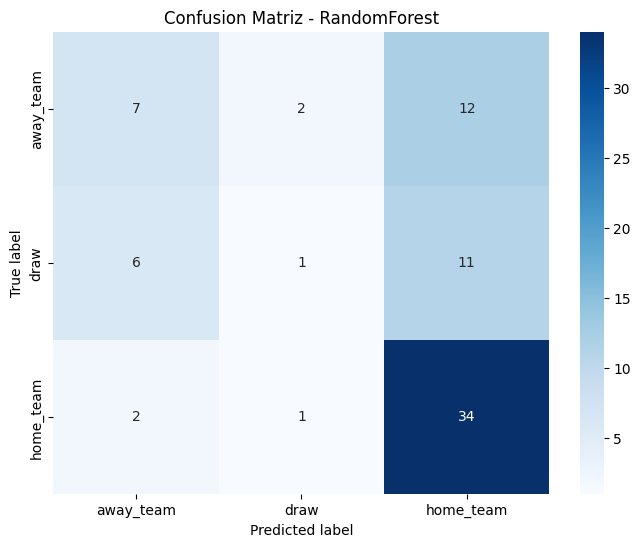

In [450]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# predicciones en el conjunto de prueba
y_pred = rf_best_model.predict(X_test)

# matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matriz - RandomForest')
plt.show()

In [451]:
from sklearn.metrics import classification_report

# reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.33      0.39        21
           1       0.25      0.06      0.09        18
           2       0.60      0.92      0.72        37

    accuracy                           0.55        76
   macro avg       0.44      0.44      0.40        76
weighted avg       0.48      0.55      0.48        76



Obtenemos la importancia de cada una de las características.

In [452]:
# importancia de características
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_best_model.named_steps['classifier'].feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importance of features:")
print(feature_importances.head(10))

Importance of features:
                                   Feature  Importance
2               shots_on_target_ratio_home    0.055509
6                       shots_high_xG_home    0.052614
100   set_piece_shots_on_target_ratio_home    0.041388
7                       shots_high_xG_away    0.036707
4    average_shots_on_target_distance_home    0.036555
3               shots_on_target_ratio_away    0.032793
101   set_piece_shots_on_target_ratio_away    0.023786
9                   shots_inside_area_away    0.021257
76                       dispossessed_home    0.019780
54                        miscontrols_home    0.017617


Reducimos los datos, utilizando las características más importantes y replicamos el proceso anterior para ver si mejora el modelo.

In [453]:
# filtramos la características con importancia mayor a un umbral
important_features = feature_importances[feature_importances['Importance'] > 0.005]['Feature']
X_reduced = X[important_features]

# dividimos los datos reducidos en entrenamiento y prueba
X_train_reduced, X_test_reduced, y_train, y_test = divide_data_in_train_test(X_reduced, y, test_size=0.2)

In [454]:
# entrenamos el modelo con las características reducidas
grid_search.fit(X_train_reduced, y_train)
# mejores parámetros
print("Best hyperparameters:", grid_search.best_params_)
# mejor modelo reducido
rf_best_model_reduced = grid_search.best_estimator_

# evaluamos el modelo
train_accuracy_reduced = rf_best_model_reduced.score(X_train_reduced, y_train)
print(f"Train Accuracy (Reduced): {train_accuracy_reduced:.4f}")
test_accuracy_reduced = rf_best_model_reduced.score(X_test_reduced, y_test)
print(f"Test Accuracy (Reduced): {test_accuracy_reduced:.4f}")

# validación cruzada
cv_scores_reduced = cross_val_score(rf_best_model_reduced, X_train_reduced, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (Reduced): {cv_scores_reduced.mean():.4f} +/- {cv_scores_reduced.std():.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 150}
Train Accuracy (Reduced): 0.9967
Test Accuracy (Reduced): 0.6711
Cross-Validation Accuracy (Reduced): 0.6285 +/- 0.0570


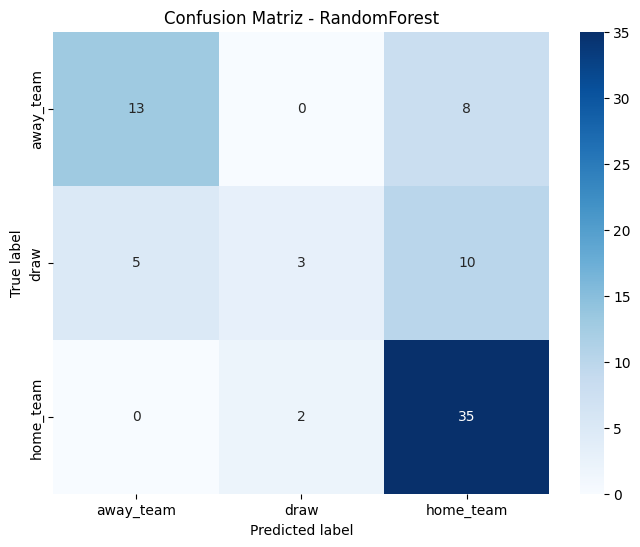

In [455]:
# predicciones en el conjunto de prueba
y_pred_reduced = rf_best_model_reduced.predict(X_test_reduced)

# matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_reduced)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matriz - RandomForest')
plt.show()

In [456]:
# reporte de clasificación
print(classification_report(y_test, y_pred_reduced))

              precision    recall  f1-score   support

           0       0.72      0.62      0.67        21
           1       0.60      0.17      0.26        18
           2       0.66      0.95      0.78        37

    accuracy                           0.67        76
   macro avg       0.66      0.58      0.57        76
weighted avg       0.66      0.67      0.62        76



##### DecisionTree

Establecemos el pipeline que vamos a utilizar y definimos la búsqueda de hiperparámetros.

In [457]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier


# definimos un pipeline para el modelo DecisionTreeClassifier
dt_pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# definimos el espacio de búsqueda de hiperparámetros
dt_param_grid = {
    'classifier__max_depth': [3, 5, 8, 10],
    'classifier__min_samples_split': [2, 5, 8],
    'classifier__min_samples_leaf': [1, 2, 4]
}

Buscamos la mejor combinación de hiperparámetros para trabajar. Una vez escogido evaluamos los datos de entrenamiento y de test.

In [458]:
from sklearn.model_selection import GridSearchCV


# realizamos la búsqueda de hiperparámetros
grid_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# mejores parámetros
print("Best hyperparameters:", grid_search.best_params_)
# mejor modelo
dt_best_model = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters: {'classifier__max_depth': 3, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}


In [459]:
# evaluación en el conjunto de entrenamiento y prueba
train_accuracy = dt_best_model.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")
test_accuracy = dt_best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.6480
Test Accuracy: 0.4605


Realizamos una validación cruzada.

In [460]:
from sklearn.model_selection import cross_val_score

# validación cruzada con el mejor modelo
cv_scores = cross_val_score(dt_best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

Cross-Validation Accuracy: 0.5133 +/- 0.0520


Realizamos una matriz de confusión y vemos todas la métricas (precision, accuracy, f1_score...) para averiguar donde falla más nuestro modelo.

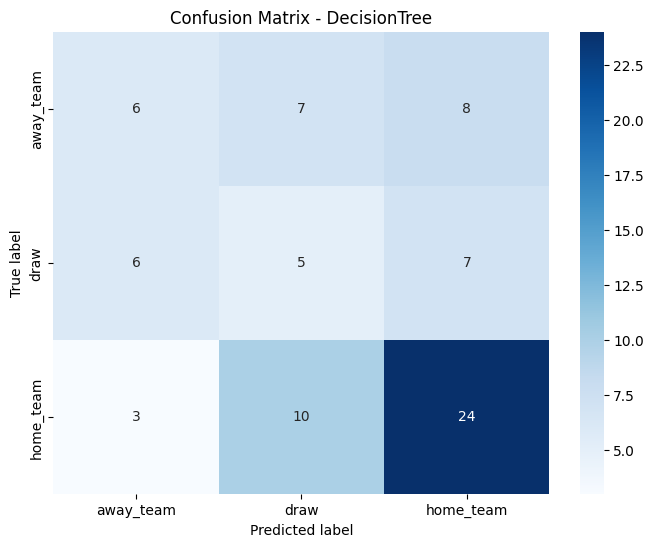

In [461]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# predicciones en el conjunto de prueba
y_pred = dt_best_model.predict(X_test)

# matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - DecisionTree')
plt.show()

In [462]:
from sklearn.metrics import classification_report

# reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.29      0.33        21
           1       0.23      0.28      0.25        18
           2       0.62      0.65      0.63        37

    accuracy                           0.46        76
   macro avg       0.41      0.40      0.40        76
weighted avg       0.46      0.46      0.46        76



Obtenemos la importancia de cada una de las características.

In [463]:
# importancia de características
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_best_model.named_steps['classifier'].feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importance of features:")
print(feature_importances.head(10))

Importance of features:
                                 Feature  Importance
4  average_shots_on_target_distance_home    0.372705
2             shots_on_target_ratio_home    0.266392
3             shots_on_target_ratio_away    0.216241
7                     shots_high_xG_away    0.144662
1                       total_shots_away    0.000000
0                       total_shots_home    0.000000
5  average_shots_on_target_distance_away    0.000000
6                     shots_high_xG_home    0.000000
8                 shots_inside_area_home    0.000000
9                 shots_inside_area_away    0.000000


Reducimos los datos, utilizando las características más importantes y replicamos el proceso anterior para ver si mejora el modelo.

In [464]:
# filtramos las características con importancia mayor a un umbral
important_features = feature_importances[feature_importances['Importance'] > 0.005]['Feature']
X_reduced = X[important_features]

# dividimos los datos reducidos en entrenamiento y prueba
X_train_reduced, X_test_reduced, y_train, y_test = divide_data_in_train_test(X_reduced, y, test_size=0.2)

In [465]:
# entrenamos el modelo con las características reducidas
grid_search.fit(X_train_reduced, y_train)
# mejores parámetros
print("Best hyperparameters:", grid_search.best_params_)
# mejor modelo reducido
dt_best_model_reduced = grid_search.best_estimator_

# evaluación del modelo reducido
train_accuracy_reduced = dt_best_model_reduced.score(X_train_reduced, y_train)
print(f"Train Accuracy (Reduced): {train_accuracy_reduced:.4f}")
test_accuracy_reduced = dt_best_model_reduced.score(X_test_reduced, y_test)
print(f"Test Accuracy (Reduced): {test_accuracy_reduced:.4f}")

# validación cruzada con el modelo reducido
cv_scores_reduced = cross_val_score(dt_best_model_reduced, X_train_reduced, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (Reduced): {cv_scores_reduced.mean():.4f} +/- {cv_scores_reduced.std():.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Train Accuracy (Reduced): 0.7237
Test Accuracy (Reduced): 0.5789
Cross-Validation Accuracy (Reduced): 0.5627 +/- 0.0500


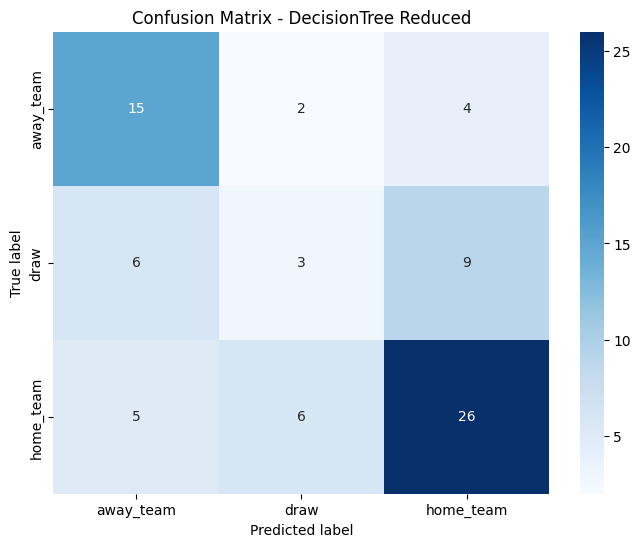

In [466]:
# predicciones en el conjunto de prueba reducido
y_pred_reduced = dt_best_model_reduced.predict(X_test_reduced)

# matriz de confusión para modelo reducido
conf_matrix = confusion_matrix(y_test, y_pred_reduced)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - DecisionTree Reduced')
plt.show()

In [467]:
# reporte de clasificación para modelo reducido
print(classification_report(y_test, y_pred_reduced))

              precision    recall  f1-score   support

           0       0.58      0.71      0.64        21
           1       0.27      0.17      0.21        18
           2       0.67      0.70      0.68        37

    accuracy                           0.58        76
   macro avg       0.51      0.53      0.51        76
weighted avg       0.55      0.58      0.56        76



##### LogisticRegression

Establecemos el pipeline que vamos a utilizar y definimos la búsqueda de hiperparámetros.

In [468]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# definimos un pipeline para el modelo LogisticRegression con StandardScaler
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# definimos el espacio de búsqueda de hiperparámetros
lr_param_grid = [
    {'classifier__penalty': ['l1'], 'classifier__solver': ['liblinear', 'saga'], 'classifier__C': [0.01, 0.1, 1, 10, 100]},
    {'classifier__penalty': ['l2'], 'classifier__solver': ['lbfgs', 'liblinear', 'saga', 'newton-cg'], 'classifier__C': [0.01, 0.1, 1, 10, 100]},
    {'classifier__penalty': ['elasticnet'], 'classifier__solver': ['saga'], 'classifier__C': [0.01, 0.1, 1, 10, 100], 'classifier__l1_ratio': [0.1, 0.5, 0.9]},
    {'classifier__penalty': [None], 'classifier__solver': ['lbfgs', 'saga', 'newton-cg']}
]

Buscamos la mejor combinación de hiperparámetros para trabajar. Una vez escogido evaluamos los datos de entrenamiento y de test.

In [469]:
from sklearn.model_selection import GridSearchCV


# realizamos la búsqueda de hiperparámetros
grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# mejores parámetros
print("Best hyperparameters:", grid_search.best_params_)
# mejor modelo
lr_best_model = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [470]:
# evaluación en el conjunto de entrenamiento y prueba
train_accuracy = lr_best_model.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")
test_accuracy = lr_best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.7961
Test Accuracy: 0.6184


Realizamos una validación cruzada.

In [471]:
from sklearn.model_selection import cross_val_score

# validación cruzada con el mejor modelo
cv_scores = cross_val_score(lr_best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

Cross-Validation Accuracy: 0.6580 +/- 0.0535


Realizamos una matriz de confusión y vemos todas la métricas (precision, accuracy, f1_score...) para averiguar donde falla más nuestro modelo.

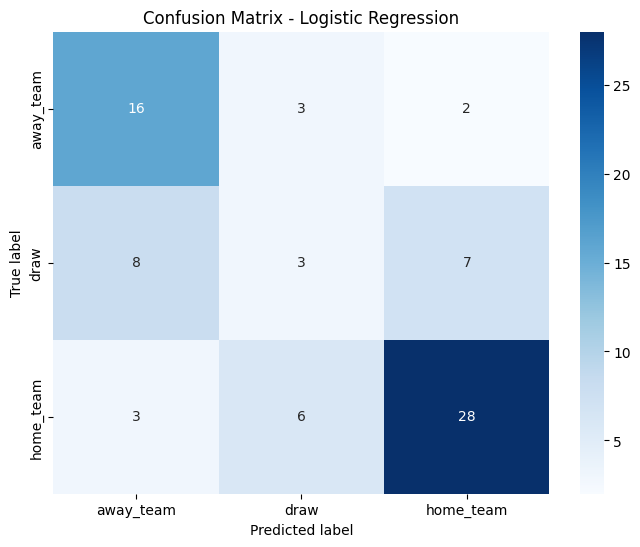

In [472]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# predicciones en el conjunto de prueba
y_pred = lr_best_model.predict(X_test)

# matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [473]:
from sklearn.metrics import classification_report

# reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.76      0.67        21
           1       0.25      0.17      0.20        18
           2       0.76      0.76      0.76        37

    accuracy                           0.62        76
   macro avg       0.53      0.56      0.54        76
weighted avg       0.59      0.62      0.60        76



Obtenemos la importancia de cada una de las características.

In [474]:
# coeficientes del modelo
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_best_model.named_steps['classifier'].coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Importance of features:")
print(feature_importances.head(10))

Importance of features:
                                   Feature  Coefficient
7                       shots_high_xG_away     0.195815
3               shots_on_target_ratio_away     0.130285
49                         clearances_away     0.113499
13                         shots_foot_away     0.106596
37                             blocks_away     0.106087
4    average_shots_on_target_distance_home     0.098053
128           goals_scored_last_match_away     0.096936
50                 penaltys_committed_home     0.095862
41                            tackles_away     0.093053
39                          duels_won_away     0.090584


Reducimos los datos, utilizando las características más importantes y replicamos el proceso anterior para ver si mejora el modelo.

In [475]:
# filtramos las características con coeficientes mayores a un umbral
important_features = feature_importances[feature_importances['Coefficient'].abs() > 0.001]['Feature']
X_reduced = X[important_features]

# dividimos los datos reducidos en entrenamiento y prueba
X_train_reduced, X_test_reduced, y_train, y_test = divide_data_in_train_test(X_reduced, y, test_size=0.2)

In [476]:
# entrenamos el modelo con las características reducidas
grid_search.fit(X_train_reduced, y_train)
# mejores parámetros
print("Best hyperparameters:", grid_search.best_params_)
# mejor modelo reducido
lr_best_model_reduced = grid_search.best_estimator_

# evaluación del modelo reducido
train_accuracy_reduced = lr_best_model_reduced.score(X_train_reduced, y_train)
print(f"Train Accuracy (Reduced): {train_accuracy_reduced:.4f}")
test_accuracy_reduced = lr_best_model_reduced.score(X_test_reduced, y_test)
print(f"Test Accuracy (Reduced): {test_accuracy_reduced:.4f}")

# validación cruzada con el modelo reducido
cv_scores_reduced = cross_val_score(lr_best_model_reduced, X_train_reduced, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (Reduced): {cv_scores_reduced.mean():.4f} +/- {cv_scores_reduced.std():.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Train Accuracy (Reduced): 0.7895
Test Accuracy (Reduced): 0.6053
Cross-Validation Accuracy (Reduced): 0.6679 +/- 0.0603


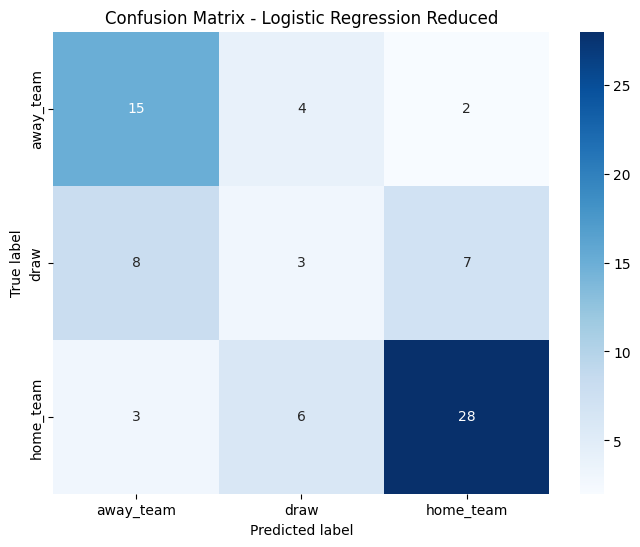

In [477]:
# predicciones en el conjunto de prueba reducido
y_pred_reduced = lr_best_model_reduced.predict(X_test_reduced)

# matriz de confusión para modelo reducido
conf_matrix = confusion_matrix(y_test, y_pred_reduced)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Logistic Regression Reduced')
plt.show()

In [478]:
# reporte de clasificación para modelo reducido
print(classification_report(y_test, y_pred_reduced))

              precision    recall  f1-score   support

           0       0.58      0.71      0.64        21
           1       0.23      0.17      0.19        18
           2       0.76      0.76      0.76        37

    accuracy                           0.61        76
   macro avg       0.52      0.55      0.53        76
weighted avg       0.58      0.61      0.59        76



##### kNN

Establecemos el pipeline que vamos a utilizar y definimos la búsqueda de hiperparámetros.

In [479]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier


# definimos un pipeline para el modelo KNeighborsClassifier con StandardScaler
knn_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', KNeighborsClassifier())
])

# definimos el espacio de búsqueda de hiperparámetros
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

Buscamos la mejor combinación de hiperparámetros para trabajar. Una vez escogido evaluamos los datos de entrenamiento y de test.

In [480]:
from sklearn.model_selection import GridSearchCV


# realizamos la búsqueda de hiperparámetros
grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# mejores parámetros
print("Best hyperparameters:", grid_search.best_params_)
# mejor modelo
knn_best_model = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}


In [481]:
# evaluación en el conjunto de entrenamiento y prueba
train_accuracy = knn_best_model.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")
test_accuracy = knn_best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 1.0000
Test Accuracy: 0.5526


Realizamos una validación cruzada.

In [482]:
# validación cruzada con el mejor modelo
cv_scores = cross_val_score(knn_best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

Cross-Validation Accuracy: 0.5497 +/- 0.0649


Realizamos una matriz de confusión y vemos todas la métricas (precision, accuracy, f1_score...) para averiguar donde falla más nuestro modelo.

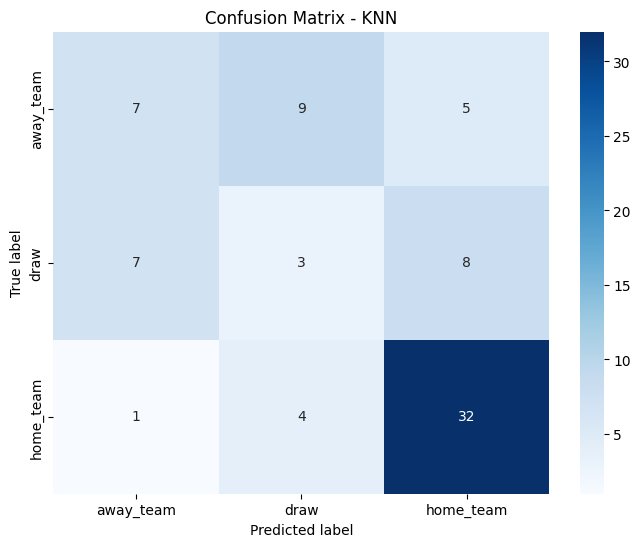

In [483]:
# predicciones en el conjunto de prueba
y_pred = knn_best_model.predict(X_test)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - KNN')
plt.show()

In [484]:
from sklearn.metrics import classification_report

# reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.33      0.39        21
           1       0.19      0.17      0.18        18
           2       0.71      0.86      0.78        37

    accuracy                           0.55        76
   macro avg       0.46      0.45      0.45        76
weighted avg       0.52      0.55      0.53        76

